In [1]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime, timedelta
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
import seaborn
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

/home/junghwan/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 개요
> 동적 자산 배분 전략인 VAA(Vigilant Asset Allocation) 전략을 구현합니다.

거칠지만 수익성이 더 좋은 동적 자산배분 전략을 알아볼 것입니다.
VAA는 꽤 공격적인 동적 자산배분 전략으로 공격 자산 또는 방어 자산으로 구성된 유니버스에서 매월 포트폴리오의 100%를 단일 자산에 할당합니다. VAA의 모멘텀 측정은 최근일수록 가중치를 더 크게 줍니다. 그러므로 VAA는 시장 변화에 더 빠르게 대응할 수 있지만 거래 횟수가 증가하여 거래 비용이 증가할 수 있습니다.

## 논문 실험

VAA 전략 논문의 저자는 글로벌 기준으로 12개 공격 자산(S&P 500, Russell 2000, NASDAQ 100, Europe Stock, Japan Stock, US REITs, Commodities, Gold, Long Term Treasury, Investment Grade Corporate Bond, High Yield Bond)과 3개 방어 자산(1-3 Year Treasury, 7-10 Year Treasury, Investment Grade Corporate Bond)을 사용하는 전략도 제시합니다. 그러나, 전략의 골격은 같고 아래에서 테스트하는 공격 자산 4개, 방어 자산 3개 조합이 더 간단하니 그렇게 합니다.

사용되는 공격 자산은 SPY (S&P 500), EFA (MSCI EAFE), EEM (Emerging), AGG (Aggregate US Bond)이고, 방어 자산은 LQD (Investment Grade Corporate Bond), IEF (US 7-10 Year Treausry), SHY (US 1-3 Year Treasury)입니다. 실제 거래를 할 때는 ETF를 사용할 것이니 유동성도 풍부하고 사용하기도 쉬운 ETF들로 테스트합니다.

In [2]:
# 공격 자산: SPY (S&P 500), EFA (MSCI EAFE), EEM (Emerging), AGG (Aggregate US Bond) 
# 방어 자산: LQD (Investment Grade Corporate Bond), IEF (US 7-10 Year Treausry), SHY (US 1-3 Year Treasury)

# AGG starts: 2003-09-29
start = datetime(2003,10,1)
end = datetime(2021,5,31)

tickers = ['SPY','EFA','EEM','AGG','LQD','SHY','IEF']

def get_price_data(tickers):
    df_asset = pd.DataFrame(columns=tickers)
    
    for ticker in tickers:
        df_asset[ticker] = pdr.get_data_yahoo(ticker, start, end)['Adj Close']  
         
    return df_asset

In [ ]:
df_asset = get_price_data(tickers)
df_asset

# 모멘텀 계산

모멘텀을 특이한 방식으로 측정합니다. 섹터 로테이션에서는 12개월 전과 비교했는데, VAA 전략은 1, 3, 6, 12개월 전과 비교하면서 최근일수록 가중치를 크게 줍니다. 365일, 180일, 90일, 30일 전이 거래일이 아닐 수 있으니 그 근처 5일을 가져오고 그 중 가장 최근 값을 취합니다.

```python
momentum = (x/before_1m - 1) * 12 + (x/before_3m - 1) * 4 + (x/before_6m - 1) * 2 + (x/before_12m - 1) * 1
```
위의 모멘텀 계산식에서 알 수 있듯이 1개월 전일 경우 12의 가중치를, 3개월 전일 경우 4의 가중치를 주는 방식으로 최근일수록 가중치를 크게 부여하는 방식입니다.

In [7]:
def get_momentum(x):
    temp = [0 for _ in range(len(x.index))]
    momentum = pd.Series(temp, index=x.index)
    
    try:
        before_1m = df_asset[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1]
        before_3m = df_asset[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1]
        before_6m = df_asset[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1]
        before_12m = df_asset[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1]
        momentum = (x/before_1m - 1) * 12 + (x/before_3m - 1) * 4 + (x/before_6m - 1) * 2 + (x/before_12m - 1) * 1
        
    except:
        pass
    
    return momentum

In [8]:
momentum_col = [col + '_m' for col in df_asset.columns]
df_asset[momentum_col] = df_asset.apply(lambda x: get_momentum(x), axis=1)
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m
Date,,,,,,,,,,,,,,
2003-09-30,69.783485,23.336910,10.737963,57.211609,52.017586,61.019886,52.190983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-01,71.270592,24.102833,11.019981,57.183723,52.167252,61.029446,52.422562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-02,71.528923,24.064934,11.177972,57.094620,51.966743,61.029446,52.234150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-03,72.185234,24.415993,11.288568,56.682358,51.244022,60.874413,51.510777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-06,72.513351,24.671301,11.332018,56.765934,51.295319,60.918686,51.662754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,413.725586,77.914711,52.565140,112.473412,128.551636,86.027878,113.185837,1.181710,1.181692,0.269094,-0.081025,-0.017870,0.009609,-0.220734
2021-05-25,412.807648,77.934067,53.085102,112.748566,129.030396,86.027878,113.601677,1.089723,1.173407,0.484627,-0.033359,0.046774,0.010535,-0.146306
2021-05-26,413.626892,77.885681,53.477524,112.709259,128.961975,86.047813,113.472954,1.186439,1.168761,0.651034,0.005785,0.101120,0.023760,-0.104925


12개월 모멘텀을 사용하였기 때문에 앞의 1년은 사용하지 못합니다.
그렇기 때문에 이를 제거하고 2004년 10월 1일부터를 확인하겠습니다.

In [9]:
df_asset = df_asset.loc[df_asset.index >= '2004-10-01']
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m
Date,,,,,,,,,,,,,,
2004-10-01,80.629272,29.089062,13.959938,58.947189,54.880219,61.789371,54.349972,0.471689,0.678516,1.598201,0.139455,0.230032,0.016278,0.183585
2004-10-04,80.764061,29.133614,14.198165,58.964542,54.845581,61.796963,54.369011,0.442062,0.799114,1.946162,0.221228,0.388862,0.056310,0.312936
2004-10-05,80.806656,29.149832,14.093345,58.958706,55.073353,61.804443,54.369011,0.439777,0.753844,1.727191,0.219027,0.462849,0.057387,0.311686
2004-10-06,81.360008,29.259216,14.256129,58.849098,54.914940,61.751629,54.190586,0.597323,0.856004,2.032841,0.182424,0.408189,0.040608,0.253899
2004-10-07,80.487358,29.058670,14.134638,58.849098,54.796047,61.728973,54.094997,0.299334,0.518999,1.720503,0.193198,0.292651,0.033623,0.204118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,413.725586,77.914711,52.565140,112.473412,128.551636,86.027878,113.185837,1.181710,1.181692,0.269094,-0.081025,-0.017870,0.009609,-0.220734
2021-05-25,412.807648,77.934067,53.085102,112.748566,129.030396,86.027878,113.601677,1.089723,1.173407,0.484627,-0.033359,0.046774,0.010535,-0.146306
2021-05-26,413.626892,77.885681,53.477524,112.709259,128.961975,86.047813,113.472954,1.186439,1.168761,0.651034,0.005785,0.101120,0.023760,-0.104925


월 말 리밸런싱을 할 것이니 월말 데이터만 남깁니다.

In [10]:
df_asset = df_asset.resample(rule='M').last()
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m
Date,,,,,,,,,,,,,,
2004-10-31,80.310005,29.646128,14.087785,59.564495,55.776421,62.015854,55.108284,0.395777,1.064305,1.396006,0.379032,0.493948,0.122001,0.460086
2004-11-30,83.885231,31.449005,15.489338,59.124298,55.095989,61.658962,54.018402,1.043382,1.672988,2.762309,0.046639,0.056559,-0.052599,-0.116249
2004-12-31,86.411942,32.960674,16.224468,59.595707,55.862423,61.802177,54.648926,0.783424,1.375681,1.929848,0.287967,0.406184,0.038828,0.276791
2005-01-31,84.474510,32.333347,16.138458,59.886703,56.548615,61.779419,55.124954,0.156558,0.583562,1.302152,0.195673,0.384642,-0.004726,0.233911
2005-02-28,86.240341,33.557148,17.701025,59.664272,56.019150,61.620384,54.370686,0.701214,1.342324,2.925695,0.023536,0.029128,-0.046535,-0.125260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,70.047760,52.300255,114.558746,131.435638,86.044785,117.165939,0.926595,1.013998,1.941232,-0.028882,-0.084927,0.031091,-0.165836
2021-02-28,374.194092,71.615356,52.712296,112.819588,128.460800,85.994980,114.396942,0.882322,0.752654,0.941667,-0.292007,-0.427845,0.016128,-0.560362
2021-03-31,391.182251,73.415176,52.329681,111.526314,126.562180,85.947144,111.667778,1.456586,1.085730,0.769575,-0.313017,-0.377557,-0.008304,-0.702033


# 자산 선택

공격 자산의 모멘텀이 모두 0 이상인 경우 공격 자산 중 모멘텀이 가장 좋은 자산에 투자합니다. 만약 공격 자산 중 1개라도 모멘텀이 음수이면 방어 자산 중 모멘텀이 가장 좋은 자산에 투자합니다. 1개라도 음수이면 방어 자산으로 전환하기 때문에 이런 면에서는 방어적이라고 볼 수 있습니다.

In [11]:
def select_asset(x):
    selected_asset = pd.Series([0,0], index=['ASSET','PRICE'])
    
    # 모든 공격 자산 > 0
    if x['SPY_m'] > 0 and x['EFA_m'] > 0 and x['EEM_m'] > 0 and x['AGG_m'] > 0:
        selected_momentum = max(x['SPY_m'], x['EFA_m'], x['EEM_m'], x['AGG_m'])
    
    # 공격 자산 중 1개라도 < 0
    else:
        selected_momentum = max(x['LQD_m'], x['SHY_m'], x['IEF_m'])
    
    selected_asset['ASSET'] = x[x==selected_momentum].index[0][:3]
    selected_asset['PRICE'] = x[selected_asset['ASSET']]
    
    return selected_asset

In [12]:
df_asset[['ASSET','PRICE']] = df_asset.apply(lambda x: select_asset(x), axis=1) 
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m,ASSET,PRICE
Date,,,,,,,,,,,,,,,,
2004-10-31,80.310005,29.646128,14.087785,59.564495,55.776421,62.015854,55.108284,0.395777,1.064305,1.396006,0.379032,0.493948,0.122001,0.460086,EEM,14.087785
2004-11-30,83.885231,31.449005,15.489338,59.124298,55.095989,61.658962,54.018402,1.043382,1.672988,2.762309,0.046639,0.056559,-0.052599,-0.116249,EEM,15.489338
2004-12-31,86.411942,32.960674,16.224468,59.595707,55.862423,61.802177,54.648926,0.783424,1.375681,1.929848,0.287967,0.406184,0.038828,0.276791,EEM,16.224468
2005-01-31,84.474510,32.333347,16.138458,59.886703,56.548615,61.779419,55.124954,0.156558,0.583562,1.302152,0.195673,0.384642,-0.004726,0.233911,EEM,16.138458
2005-02-28,86.240341,33.557148,17.701025,59.664272,56.019150,61.620384,54.370686,0.701214,1.342324,2.925695,0.023536,0.029128,-0.046535,-0.125260,EEM,17.701025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,70.047760,52.300255,114.558746,131.435638,86.044785,117.165939,0.926595,1.013998,1.941232,-0.028882,-0.084927,0.031091,-0.165836,SHY,86.044785
2021-02-28,374.194092,71.615356,52.712296,112.819588,128.460800,85.994980,114.396942,0.882322,0.752654,0.941667,-0.292007,-0.427845,0.016128,-0.560362,SHY,85.994980
2021-03-31,391.182251,73.415176,52.329681,111.526314,126.562180,85.947144,111.667778,1.456586,1.085730,0.769575,-0.313017,-0.377557,-0.008304,-0.702033,SHY,85.947144


In [13]:
return_col = [ticker + '_r' for ticker in tickers]
df_asset[return_col] = df_asset[tickers].pct_change()
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,...,IEF_m,ASSET,PRICE,SPY_r,EFA_r,EEM_r,AGG_r,LQD_r,SHY_r,IEF_r
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-31,80.310005,29.646128,14.087785,59.564495,55.776421,62.015854,55.108284,0.395777,1.064305,1.396006,...,0.460086,EEM,14.087785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-30,83.885231,31.449005,15.489338,59.124298,55.095989,61.658962,54.018402,1.043382,1.672988,2.762309,...,-0.116249,EEM,15.489338,0.044518,0.060813,0.099487,-0.007390,-0.012199,-0.005755,-0.019777
2004-12-31,86.411942,32.960674,16.224468,59.595707,55.862423,61.802177,54.648926,0.783424,1.375681,1.929848,...,0.276791,EEM,16.224468,0.030121,0.048067,0.047460,0.007973,0.013911,0.002323,0.011672
2005-01-31,84.474510,32.333347,16.138458,59.886703,56.548615,61.779419,55.124954,0.156558,0.583562,1.302152,...,0.233911,EEM,16.138458,-0.022421,-0.019033,-0.005301,0.004883,0.012284,-0.000368,0.008711
2005-02-28,86.240341,33.557148,17.701025,59.664272,56.019150,61.620384,54.370686,0.701214,1.342324,2.925695,...,-0.125260,EEM,17.701025,0.020904,0.037849,0.096823,-0.003714,-0.009363,-0.002574,-0.013683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,70.047760,52.300255,114.558746,131.435638,86.044785,117.165939,0.926595,1.013998,1.941232,...,-0.165836,SHY,86.044785,-0.010190,-0.007813,0.031740,-0.007446,-0.018316,0.000232,-0.010921
2021-02-28,374.194092,71.615356,52.712296,112.819588,128.460800,85.994980,114.396942,0.882322,0.752654,0.941667,...,-0.560362,SHY,85.994980,0.027806,0.022379,0.007878,-0.015181,-0.022633,-0.000579,-0.023633
2021-03-31,391.182251,73.415176,52.329681,111.526314,126.562180,85.947144,111.667778,1.456586,1.085730,0.769575,...,-0.702033,SHY,85.947144,0.045399,0.025132,-0.007259,-0.011463,-0.014780,-0.000556,-0.023857


# 월별 수익률 계산

전략의 월별 수익률을 계산합니다. 이에 대한 요약은 아래와 같습니다.
- 200 개월 중 수익 월 : 140 개월
- 200 개월 중 손실 월 : 60 개월
- 승률 : 70.0
- CAGR :  14.69
- MDD :  -11.97
- STDEV : 11.85
- Return-Risk Ratio:  1.24

In [14]:
df_asset['RETURN'] = 0
df_asset['RETURN_ACC'] = 0
df_asset['LOG_RETURN'] = 0
df_asset['LOG_RETURN_ACC'] = 0

for i in range(len(df_asset)):
    strat_return = 0
    log_strat_return = 0
    
    # 직전 달 모멘텀이 좋은 것으로 리밸런싱해서 앞으로 한 달 가져가는 것
    if i > 0:
        strat_return = df_asset[df_asset.iloc[i-1]['ASSET']+'_r'].iloc[i]
        log_strat_return = math.log(strat_return + 1)
        
    df_asset.loc[df_asset.index[i], 'RETURN'] = strat_return
    # 누적 = 직전 누적 * 현재
    df_asset.loc[df_asset.index[i], 'RETURN_ACC'] = (1+df_asset.loc[df_asset.index[i-1], 'RETURN_ACC'])*(1+strat_return)-1
    df_asset.loc[df_asset.index[i], 'LOG_RETURN'] = log_strat_return
    # 로그누적 = 직전 로그누적 + 현재 로그
    df_asset.loc[df_asset.index[i], 'LOG_RETURN_ACC'] = df_asset.loc[df_asset.index[i-1], 'LOG_RETURN_ACC'] + log_strat_return
    
# 수익률 * 100
df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']] = df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']]*100
df_asset[return_col] = df_asset[return_col] * 100

In [15]:
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,...,EFA_r,EEM_r,AGG_r,LQD_r,SHY_r,IEF_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-31,80.310005,29.646128,14.087785,59.564495,55.776421,62.015854,55.108284,0.395777,1.064305,1.396006,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2004-11-30,83.885231,31.449005,15.489338,59.124298,55.095989,61.658962,54.018402,1.043382,1.672988,2.762309,...,6.081325,9.948712,-0.739026,-1.219927,-0.575485,-1.977710,9.948712,9.948712,9.484382,9.484382
2004-12-31,86.411942,32.960674,16.224468,59.595707,55.862423,61.802177,54.648926,0.783424,1.375681,1.929848,...,4.806731,4.746041,0.797318,1.391088,0.232270,1.167239,4.746041,15.166923,4.636858,14.121239
2005-01-31,84.474510,32.333347,16.138458,59.886703,56.548615,61.779419,55.124954,0.156558,0.583562,1.302152,...,-1.903259,-0.530125,0.488284,1.228360,-0.036825,0.871066,-0.530125,14.556394,-0.531535,13.589704
2005-02-28,86.240341,33.557148,17.701025,59.664272,56.019150,61.620384,54.370686,0.701214,1.342324,2.925695,...,3.784949,9.682255,-0.371420,-0.936300,-0.257423,-1.368289,9.682255,25.648037,9.241741,22.831445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,70.047760,52.300255,114.558746,131.435638,86.044785,117.165939,0.926595,1.013998,1.941232,...,-0.781264,3.173996,-0.744569,-1.831585,0.023174,-1.092128,3.173996,876.806482,3.124666,227.911837
2021-02-28,374.194092,71.615356,52.712296,112.819588,128.460800,85.994980,114.396942,0.882322,0.752654,0.941667,...,2.237897,0.787837,-1.518137,-2.263342,-0.057882,-2.363312,-0.057882,876.241084,-0.057899,227.853938
2021-03-31,391.182251,73.415176,52.329681,111.526314,126.562180,85.947144,111.667778,1.456586,1.085730,0.769575,...,2.513176,-0.725854,-1.146320,-1.477977,-0.055627,-2.385697,-0.055627,875.698032,-0.055642,227.798296


In [16]:
# MDD

df_asset['BALANCE'] = (1+df_asset['RETURN']/100).cumprod()
df_asset['DRAWDOWN'] = -(df_asset['BALANCE'].cummax() - df_asset['BALANCE']) / df_asset['BALANCE'].cummax()

df_asset[['BALANCE','DRAWDOWN']] = df_asset[['BALANCE','DRAWDOWN']] * 100
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,...,AGG_r,LQD_r,SHY_r,IEF_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC,BALANCE,DRAWDOWN
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-31,80.310005,29.646128,14.087785,59.564495,55.776421,62.015854,55.108284,0.395777,1.064305,1.396006,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,100.000000,-0.000000
2004-11-30,83.885231,31.449005,15.489338,59.124298,55.095989,61.658962,54.018402,1.043382,1.672988,2.762309,...,-0.739026,-1.219927,-0.575485,-1.977710,9.948712,9.948712,9.484382,9.484382,109.948712,-0.000000
2004-12-31,86.411942,32.960674,16.224468,59.595707,55.862423,61.802177,54.648926,0.783424,1.375681,1.929848,...,0.797318,1.391088,0.232270,1.167239,4.746041,15.166923,4.636858,14.121239,115.166923,-0.000000
2005-01-31,84.474510,32.333347,16.138458,59.886703,56.548615,61.779419,55.124954,0.156558,0.583562,1.302152,...,0.488284,1.228360,-0.036825,0.871066,-0.530125,14.556394,-0.531535,13.589704,114.556394,-0.530125
2005-02-28,86.240341,33.557148,17.701025,59.664272,56.019150,61.620384,54.370686,0.701214,1.342324,2.925695,...,-0.371420,-0.936300,-0.257423,-1.368289,9.682255,25.648037,9.241741,22.831445,125.648037,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,364.070892,70.047760,52.300255,114.558746,131.435638,86.044785,117.165939,0.926595,1.013998,1.941232,...,-0.744569,-1.831585,0.023174,-1.092128,3.173996,876.806482,3.124666,227.911837,976.806482,-0.000000
2021-02-28,374.194092,71.615356,52.712296,112.819588,128.460800,85.994980,114.396942,0.882322,0.752654,0.941667,...,-1.518137,-2.263342,-0.057882,-2.363312,-0.057882,876.241084,-0.057899,227.853938,976.241084,-0.057882
2021-03-31,391.182251,73.415176,52.329681,111.526314,126.562180,85.947144,111.667778,1.456586,1.085730,0.769575,...,-1.146320,-1.477977,-0.055627,-2.385697,-0.055627,875.698032,-0.055642,227.798296,975.698032,-0.113477


In [17]:
total_month = len(df_asset)
profit_month = len(df_asset[df_asset['RETURN'] >= 0])
loss_month = len(df_asset[df_asset['RETURN'] < 0])
win_rate = profit_month / total_month * 100
CAGR = ((1+df_asset['RETURN_ACC'][-1]/100)**(1/(total_month/12)))-1
STDEV = np.std(df_asset['RETURN'][1:])*math.sqrt(12)
RRR = CAGR * 100 / STDEV

print(total_month, "개월 중 수익 월 :", profit_month, "개월")
print(total_month, "개월 중 손실 월 :", loss_month, "개월")
print("승률 :", round(win_rate, 2))

print('CAGR : ', round(CAGR*100, 2))
print('MDD : ', round(df_asset['DRAWDOWN'].min(), 2))
print('STDEV :', round(STDEV, 2))
print('Return-Risk Ratio: ', round(RRR, 2))

200 개월 중 수익 월 : 140 개월
200 개월 중 손실 월 : 60 개월
승률 : 70.0
CAGR :  14.69
MDD :  -11.97
STDEV : 11.85
Return-Risk Ratio:  1.24


<AxesSubplot:xlabel='Date', ylabel='LOG_RETURN_ACC'>

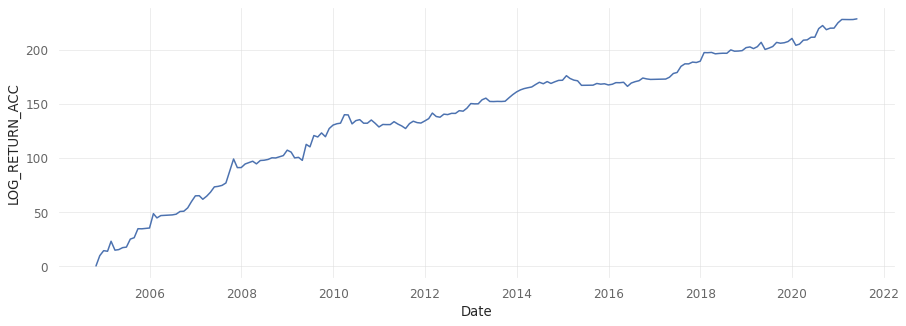

In [18]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['LOG_RETURN_ACC'])

<AxesSubplot:xlabel='Date', ylabel='DRAWDOWN'>

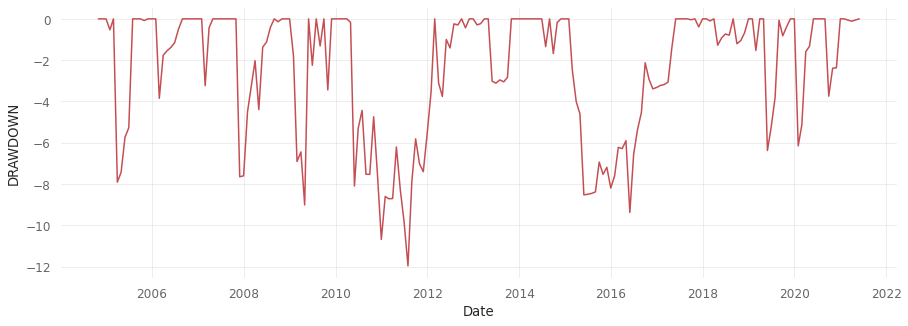

In [20]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['DRAWDOWN'], color='r')

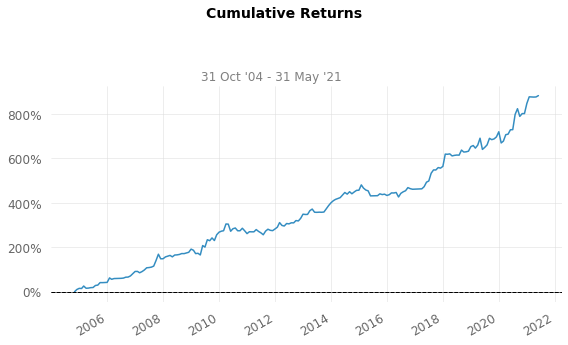

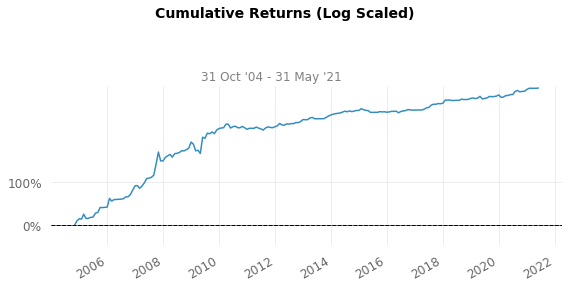

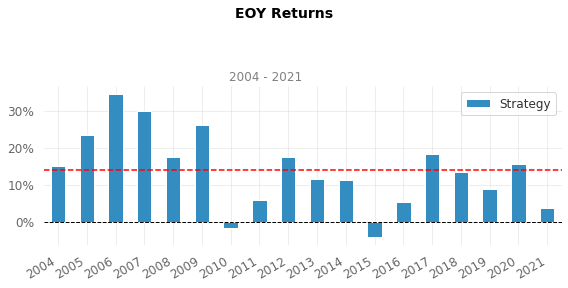

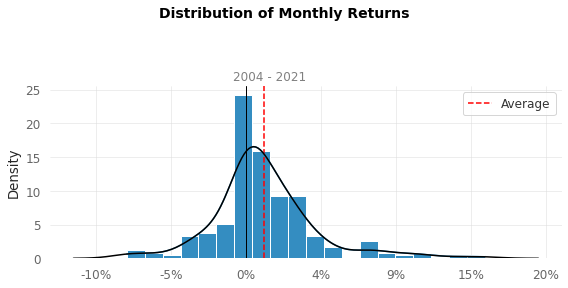

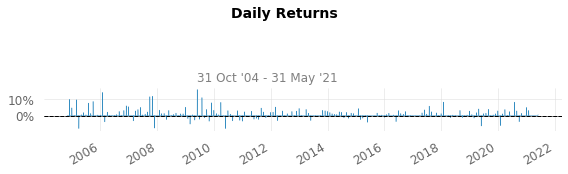

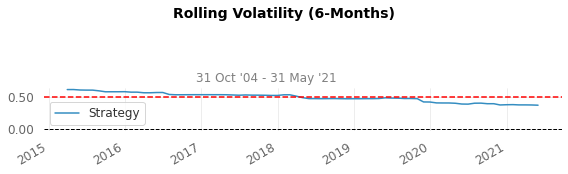

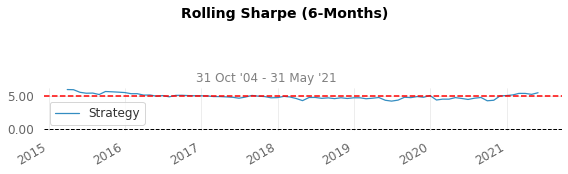

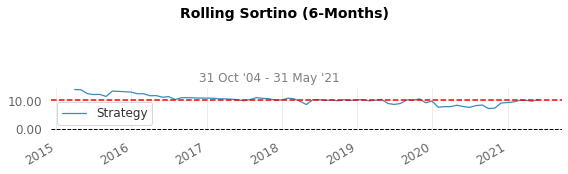

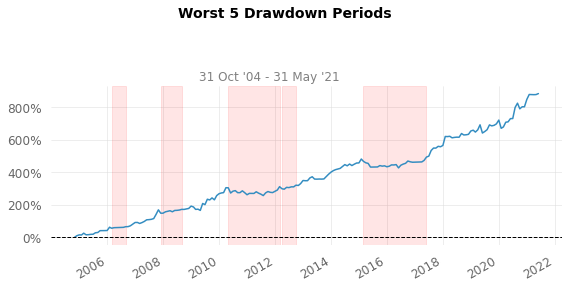

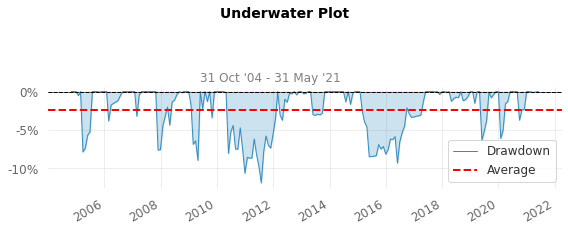

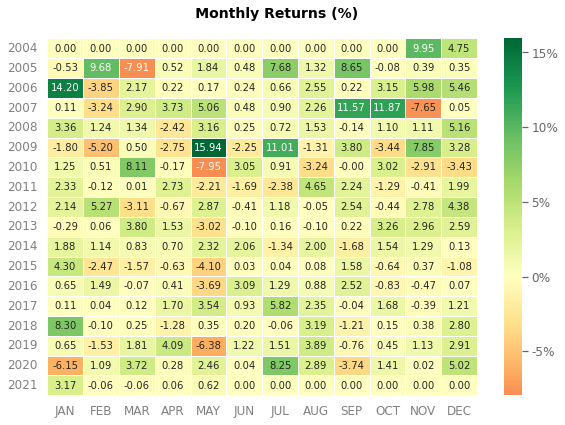

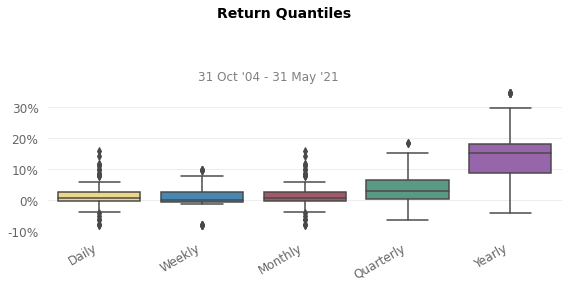

In [22]:
quantstats.reports.plots(df_asset['RETURN']/100, mode='full')

In [23]:
quantstats.reports.html(df_asset['RETURN']/100, 'SPY')